Python program to implement Credit Card Fraud detection using Support Vector Machine classification.

Link for the Dataset:

https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

## The Code

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

from warnings import filterwarnings
filterwarnings('ignore')

### Load the dataset into a DataFrame

In [3]:
# Download the csv from the kaggle website and Load the dataset into a DataFrame
def load_dataset():
    # TODO: Load the dataset
    # Define the dataset as a Pandas DataFrame
    # fetch dataset
    df = pd.read_csv('card_transdata.csv')

    # data (as pandas dataframes)
    return df

### Function for applying DQM Checks

In [4]:
def data_quality_checks(df):
    # Handling missing values
    print(f"\nAmount of missing data: {df.isnull().sum().sum()}")
    df.dropna(inplace=True)

    # Check for duplicates
    print(f"\nAmount of duplicate data: {df.duplicated().sum()}\n")
    df.drop_duplicates(inplace=True)

    # Check for unique values in categorical columns
    for col in df.columns:
        print(f"Unique values in {col} : {df[col].nunique()}")

    # Check for outliers using z-score
    numerical_columns = df.select_dtypes(exclude=["object"]).columns
    z_scores = np.abs((df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std())
    outliers = (z_scores > 3).any(axis=1)
    print(f"\nOutliers Detected by Z-Score: {df[outliers].shape[0]}\n")

### Applying profiling and visualization

In [5]:
def profiling_visualization(df):
    # Display basic information about the dataset
    df.info()
    print()

    # Descriptive statistics
    display(df.describe())

    # Categorical feature profiling
    print("\nCategorical Feature Profiling:")
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        # take top 16 values only and plot them in a bar chart
        plt.title(f"{col} Distribution", fontdict={'fontsize': 20})
        df[col].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
        plt.xticks(rotation=90)
        plt.show()
    print("-"*50)

    # Numerical feature profiling
    print("\nNumerical Feature Profiling:")
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_columns:
        fig , ax = plt.subplots(1,2, figsize=(13,5))
        plt.suptitle(f"{col} Distribution", fontsize= 20)
        data = df[col].sample(200, random_state=42)
        ax[0].set_title(f"{col} Histogram", fontdict={'fontsize': 10})
        sns.histplot(data, ax=ax[0])
        ax[1].set_title(f"{col} Boxplot", fontdict={'fontsize': 10})
        sns.boxplot(data, ax=ax[1], orient='h')
        plt.show()
    print("-"*50)

### Function for Feature engineering

In [6]:
def feature_engineering(df):
    # Normalize the Numerical values
    stdscaler = StandardScaler()
    df.iloc[:,:3] = stdscaler.fit_transform(df.iloc[:,:3])

    # Remove class imbalance from the target variable present in the dataset
    X = df.drop('fraud', axis=1)  # Features
    y = df['fraud']  # Labels

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Display the class distribution before and after SMOTE
    print("Class distribution before SMOTE:\n", y.value_counts())
    print("\nClass distribution after SMOTE:\n", y_resampled.value_counts())

    # creating a new DataFrame with the resampled data
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='fraud')], axis=1)

    df_resampled.iloc[:,3:] = df_resampled.iloc[:,3:].astype("int64")

    return df_resampled

### Train test split

In [7]:
def split_data(df):
    # Split the data into train test ratio for further processing using sklearn
    sample_df = df.groupby('fraud', group_keys=False).apply(lambda x: x.sample(min(len(x), 50000), random_state=42))
    
    X = sample_df.drop("fraud", axis=1)
    y = sample_df["fraud"]
    
    X_train, X_test, y_train, t_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, t_test

### Prediction using SVM

In [8]:
def make_SVM_predict(X_train, X_test,y_train):
    # Code to instantiate the SVM model with proper hyperparameters
    # Define individual SVM models
    svm_model1 = SVC(kernel='linear', C=5, probability=True)
    svm_model2 = SVC(kernel='rbf', C=5, probability=True)
    svm_model3 = SVC(kernel="poly",degree=3, C=5, probability=True)
    
    # Create an ensemble using a voting classifier
    ensemble_model = VotingClassifier(estimators=[('svm1', svm_model1), 
                                                  ('svm2', svm_model2), 
                                                  ('svm3', svm_model3)], voting='soft', n_jobs=-1)

    # Train the ensemble model
    start = time()
    ensemble_model.fit(X_train, y_train)
    print(f"Training time: {time() - start} seconds")

    # Make predictions
    start = time()
    y_pred = ensemble_model.predict(X_test)
    print(f"Prediction time: {time() - start} seconds")
    
    return y_pred

### Evaluate

In [9]:
def evaluate(y_pred, y_test):
    # Use different metrics to find the score of predicted result
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}\n')
    
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()

### Main function to call the functions and to predict and evaluate the predictions

In [10]:
df = load_dataset()
display(df.head())

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0



Amount of missing data: 0

Amount of duplicate data: 0

Unique values in distance_from_home : 1000000
Unique values in distance_from_last_transaction : 1000000
Unique values in ratio_to_median_purchase_price : 1000000
Unique values in repeat_retailer : 2
Unique values in used_chip : 2
Unique values in used_pin_number : 2
Unique values in online_order : 2
Unique values in fraud : 2

Outliers Detected by Z-Score: 104695

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number    

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000



Categorical Feature Profiling:
--------------------------------------------------

Numerical Feature Profiling:


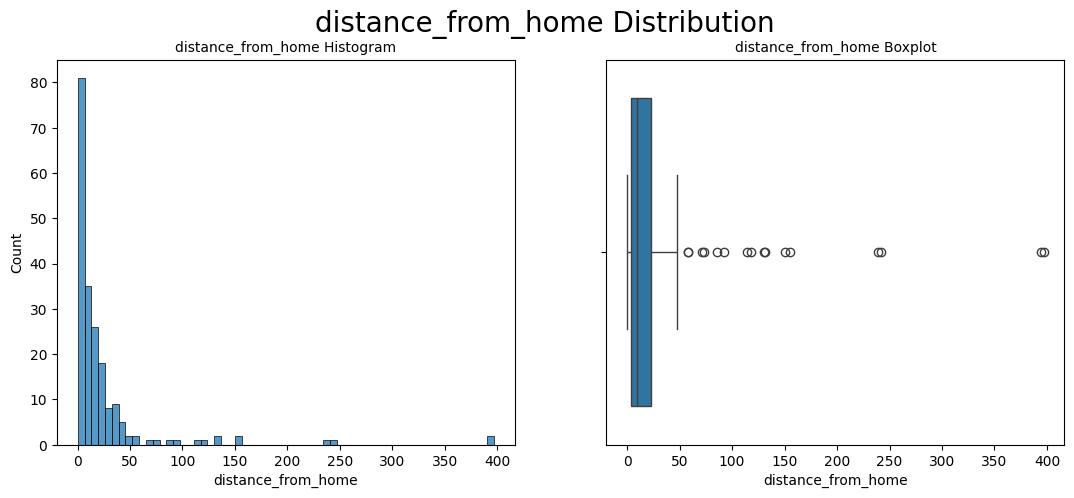

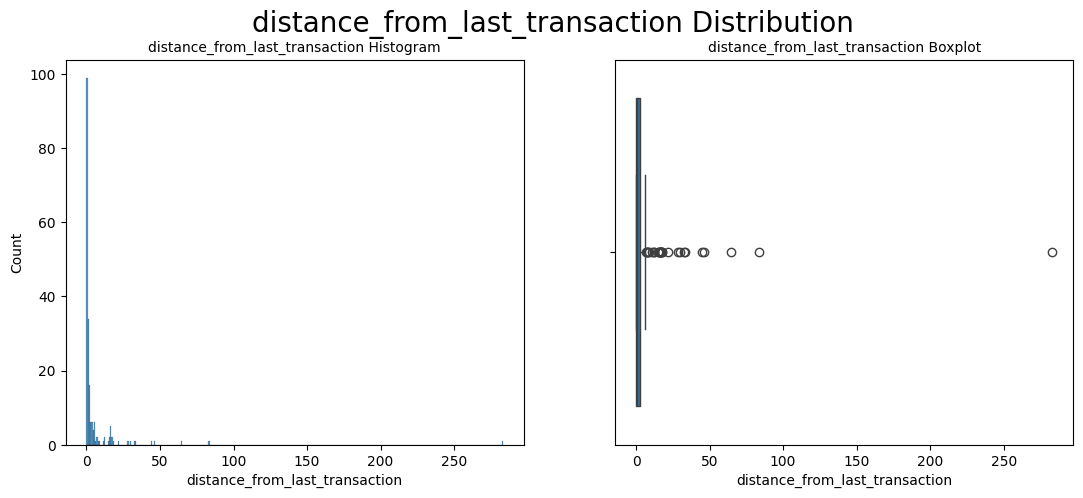

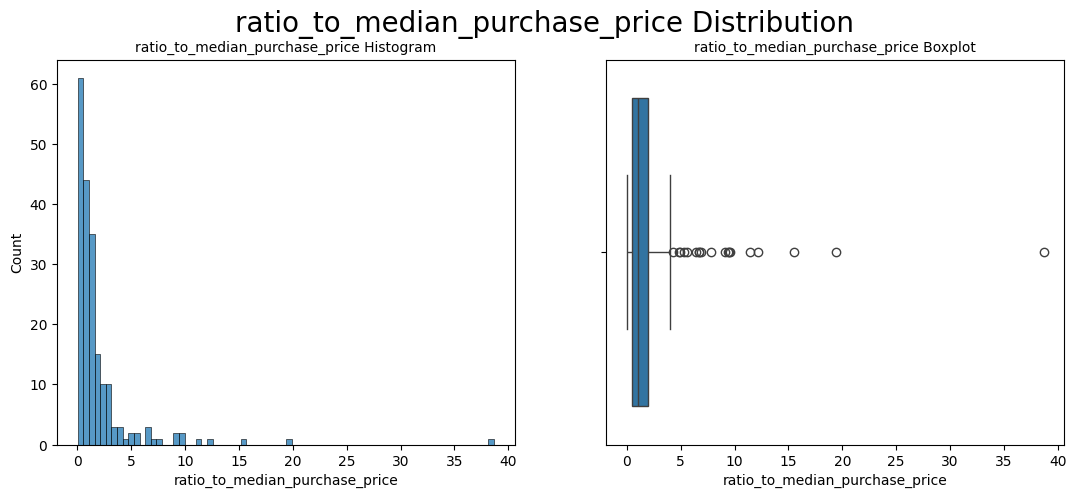

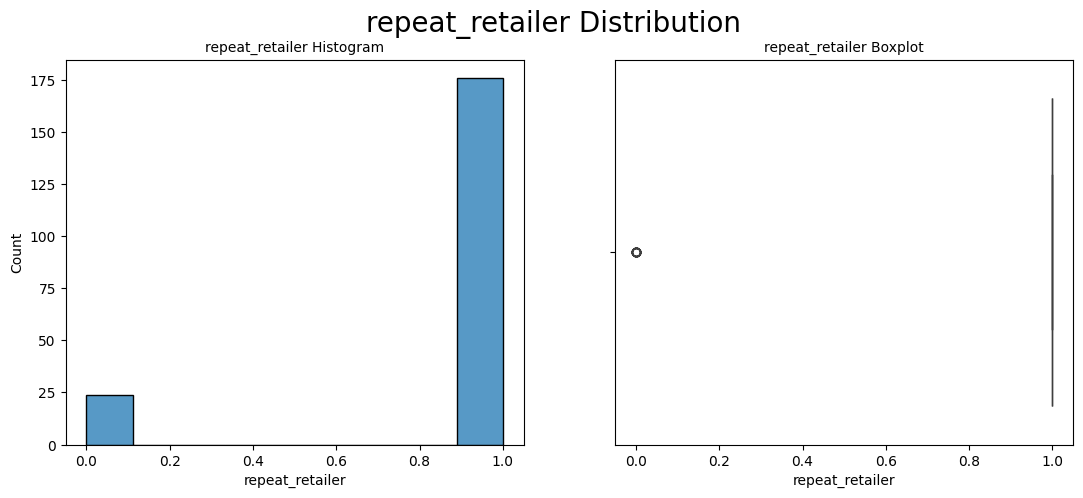

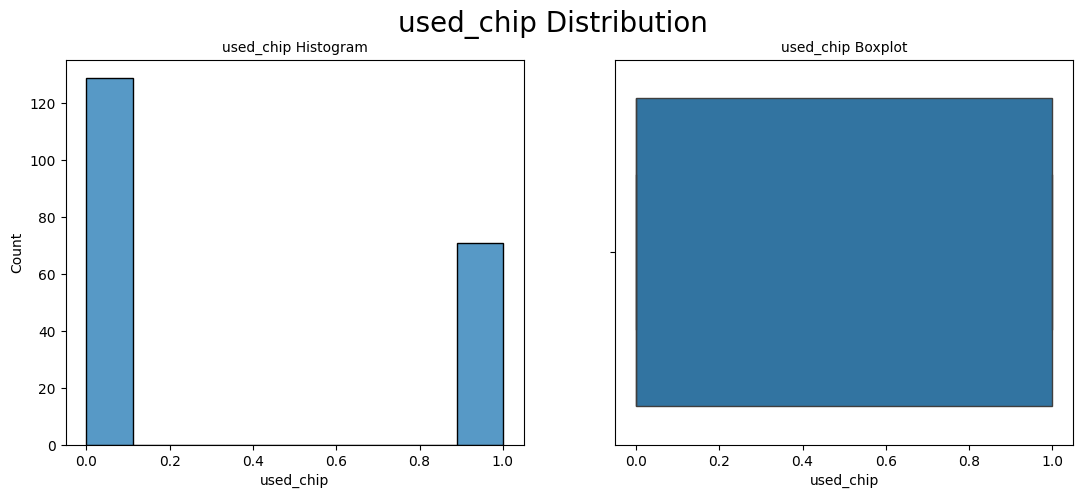

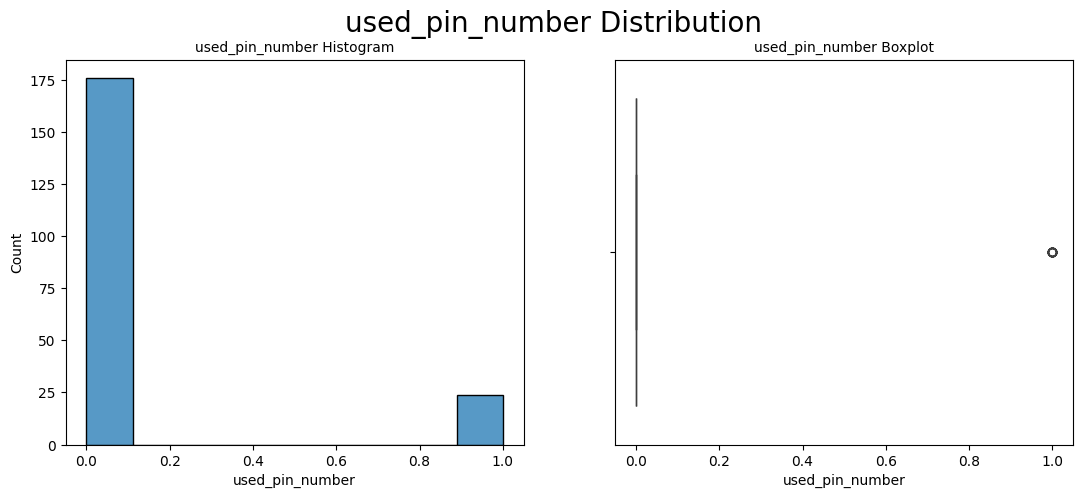

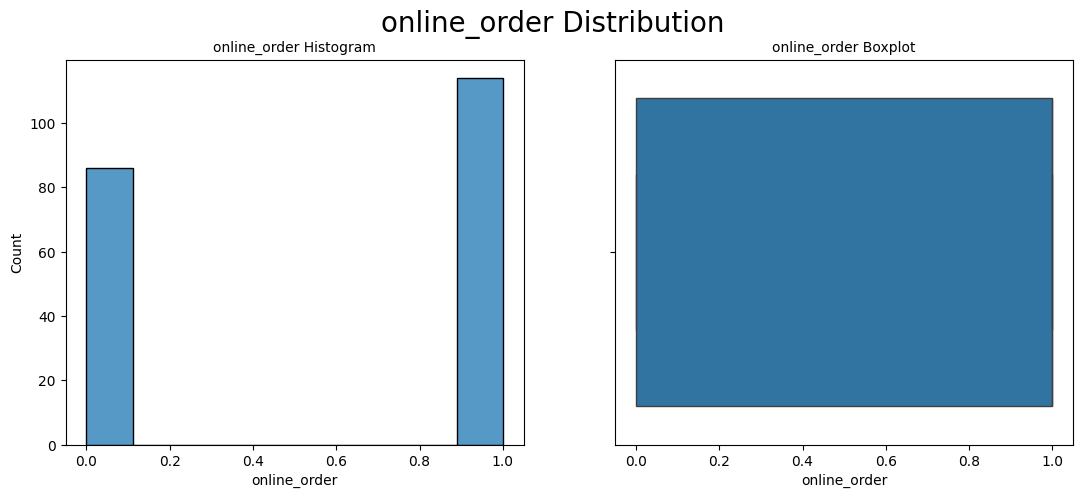

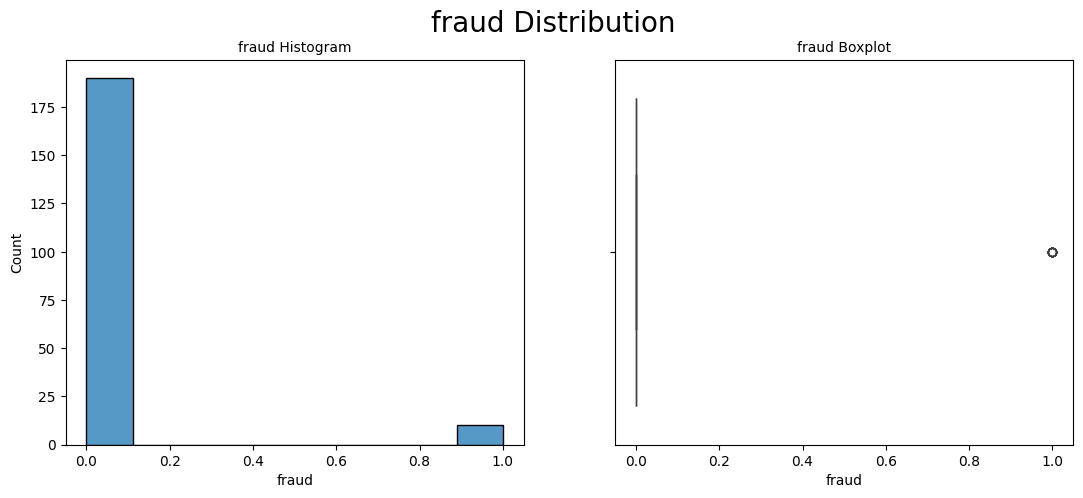

--------------------------------------------------


In [11]:
data_quality_checks(df)
profiling_visualization(df)

In [12]:
df = feature_engineering(df)

Class distribution before SMOTE:
 fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

Class distribution after SMOTE:
 fraud
0.0    912597
1.0    912597
Name: count, dtype: int64


In [13]:
X_train, X_test ,y_train, y_test = split_data(df)
print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")


Shape of X_train: (80000, 7), y_train: (80000,), X_test: (20000, 7), y_test: (20000,)


In [14]:
print("\nTraining the model...\n")
y_pred = make_SVM_predict(X_train, X_test, y_train)


Training the model...

Training time: 626.1017932891846 seconds
Prediction time: 13.295952320098877 seconds



Evaluating the model...

Accuracy: 0.9864
Precision: 0.986645245506577
Recall: 0.9860511791269443
F1 Score: 0.9863481228668942

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     10035
         1.0       0.99      0.99      0.99      9965

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



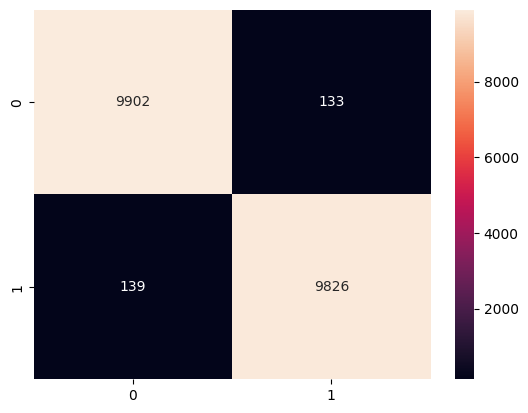

In [15]:
print("\nEvaluating the model...\n")   
evaluate(y_pred, y_test)